In [51]:
from pathlib import Path
import json

data_lst = []
for result_json in Path("saved").glob("*_benchmark_result.json"):
    print(result_json)
    data = json.loads(result_json.read_text())
    data_lst.append(data)

saved/microsoft_resnet-50_tvm_4_benchmark_result.json
saved/facebook_convnext-tiny-224_tvm_16_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_1_benchmark_result.json
saved/microsoft_resnet-50_torch_compile_4_benchmark_result.json
saved/microsoft_resnet-50_torch_compile_1_benchmark_result.json
saved/microsoft_resnet-50_tvm_1_benchmark_result.json
saved/microsoft_resnet-50_tvm_16_benchmark_result.json
saved/microsoft_resnet-50_torch_compile_16_benchmark_result.json
saved/facebook_convnext-tiny-224_tvm_4_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_16_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_compile_16_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_4_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_compile_1_benchmark_result.json
saved/microsoft_resnet-50_torch_4_benchmark_result.json
saved/microsoft_resnet-50_torch_16_benchmark_result.json
saved/facebook_convnext-tiny-224_torch_compile_4_benchmark_result.json
save

In [52]:
print(data_lst[1].keys())
print(data_lst[1]["kwargs_dic"].keys())

dict_keys(['td_compile', 'td_inference_lst', 'td_inference_mean', 'td_inference_std', 'td_inference_median', 'kwargs_dic'])
dict_keys(['image_url', 'epochs', 'warmup_epochs', 'device', 'result_json', 'log_file', 'batch_size', 'model_name', 'test_item'])


In [53]:
import pandas as pd


def data_to_record(data):
    record = {}
    record["model_name"] = data["kwargs_dic"]["model_name"]
    record["test_item"] = data["kwargs_dic"]["test_item"]
    record["batch_size"] = data["kwargs_dic"]["batch_size"]
    record["compile_time_s"] = data.get("td_compile", None)
    record["infer_time_mean_ms"] = data["td_inference_mean"] * 1000
    return record


records = [data_to_record(data) for data in data_lst]
df = pd.DataFrame(records).sort_values(by=["model_name", "batch_size", "test_item"])
df.to_csv("benchmark_result.csv", index=False)

In [54]:
df = pd.read_csv("benchmark_result.csv")
display(df)
print(df.to_markdown().replace("nan", "/"))

,model_name,test_item,batch_size,compile_time_s,infer_time_mean_ms
0,facebook/convnext-tiny-224,torch,1,NaN,4.479475
1,facebook/convnext-tiny-224,torch_compile,1,2.570267,3.450689
2,facebook/convnext-tiny-224,tvm,1,37.712660,4.572787
3,facebook/convnext-tiny-224,torch,4,NaN,4.479696
4,facebook/convnext-tiny-224,torch_compile,4,2.051283,3.378676
5,facebook/convnext-tiny-224,tvm,4,43.325187,13.611638
6,facebook/convnext-tiny-224,torch,16,NaN,6.630247
7,facebook/convnext-tiny-224,torch_compile,16,1.995230,4.622281
8,facebook/convnext-tiny-224,tvm,16,71.284512,53.154003
9,microsoft/resnet-50,torch,1,NaN,5.517545


|    | model_name                 | test_item     |   batch_size |   compile_time_s |   infer_time_mean_ms |
|---:|:---------------------------|:--------------|-------------:|-----------------:|---------------------:|
|  0 | facebook/convnext-tiny-224 | torch         |            1 |        /       |              4.47948 |
|  1 | facebook/convnext-tiny-224 | torch_compile |            1 |          2.57027 |              3.45069 |
|  2 | facebook/convnext-tiny-224 | tvm           |            1 |         37.7127  |              4.57279 |
|  3 | facebook/convnext-tiny-224 | torch         |            4 |        /       |              4.4797  |
|  4 | facebook/convnext-tiny-224 | torch_compile |            4 |          2.05128 |              3.37868 |
|  5 | facebook/convnext-tiny-224 | tvm           |            4 |         43.3252  |             13.6116  |
|  6 | facebook/convnext-tiny-224 | torch         |           16 |        /       |              6.63025 |
|  7 | facebook/convnext-

In [62]:
def table_compile_time(df: pd.DataFrame):
    table = df.pivot_table(
        index=["model_name", "batch_size"],
        columns=["test_item"],
        values="compile_time_s",
        aggfunc="mean",
    )
    table = table.round(3)
    return table


df2 = table_compile_time(df)
display(df2)

print(df2.to_latex())

# to latex line join by &
bsz_lst = [1, 4, 16] * 2
for row, bsz in zip(df2.iterrows(), bsz_lst):
    print(
        f" & {bsz} & / & "
        + " & ".join(map(lambda x: f"{x:.3f}", row[1].values))
        + r" \\"
    )

test_item                              torch_compile     tvm
model_name                 batch_size                       
facebook/convnext-tiny-224 1                   2.570  37.713
                           4                   2.051  43.325
                           16                  1.995  71.285
microsoft/resnet-50        1                   2.235  62.448
                           4                   1.966  66.616
                           16                  1.893  66.115

\begin{tabular}{llrr}
\toprule
 & test_item & torch_compile & tvm \\
model_name & batch_size &  &  \\
\midrule
\multirow[t]{3}{*}{facebook/convnext-tiny-224} & 1 & 2.570000 & 37.713000 \\
 & 4 & 2.051000 & 43.325000 \\
 & 16 & 1.995000 & 71.285000 \\
\cline{1-4}
\multirow[t]{3}{*}{microsoft/resnet-50} & 1 & 2.235000 & 62.448000 \\
 & 4 & 1.966000 & 66.616000 \\
 & 16 & 1.893000 & 66.115000 \\
\cline{1-4}
\bottomrule
\end{tabular}

 & 1 & / & 2.570 & 37.713 \\
 & 4 & / & 2.051 & 43.325 \\
 & 16 & / & 1.995 & 71.285 \\
 & 1 & / & 2.235 & 62.448 \\
 & 4 & / & 1.966 & 66.616 \\
 & 16 & / & 1.893 & 66.115 \\


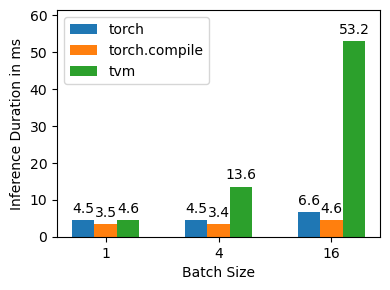

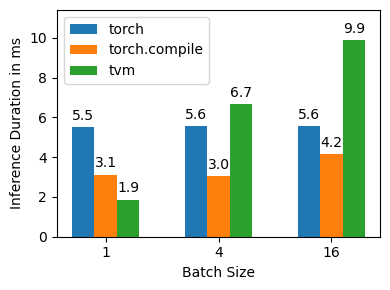

In [56]:
import matplotlib.pyplot as plt
import numpy as np

better_test_item_name = {
    "torch": "torch",
    "torch_compile": "torch.compile",
    "tvm": "tvm",
}


def plot_infer_time(df: pd.DataFrame, model_name: str, width: float = 0.2):
    df = df[df["model_name"] == model_name]

    fig, ax = plt.subplots(figsize=(4, 3))

    batch_sizes = df["batch_size"].unique()
    test_items = df["test_item"].unique()
    x = np.arange(len(batch_sizes))

    for i, test_item in enumerate(test_items):
        means = df[df["test_item"] == test_item].sort_values(by="batch_size")[
            "infer_time_mean_ms"
        ]
        bars = ax.bar(
            x + (i - 1) * width, means, width, label=better_test_item_name[test_item]
        )

        # Add text labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                "{}".format(np.round(height, 1)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Inference Duration in ms")
    # ax.set_title(f"Inference Duration for {model_name} by Batch Size and Test Item")
    ax.set_xticks(x)
    ax.set_xticklabels(batch_sizes)
    ax.legend()

    # more upper space
    ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
    return fig


for model_name in df["model_name"].unique():
    fig = plot_infer_time(df, model_name)
    fig.tight_layout()
    fig.savefig(
        Path("saved") / f"{model_name.replace('/', '_')}_infer_time.pdf",
        bbox_inches="tight",
    )
    fig.savefig(
        Path("docs") / f"{model_name.replace('/', '_')}_infer_time.png",
        bbox_inches="tight",
    )